# A software-defined BioMEMS SoC for early breast cancer detection using open-source IP

*"open in Colab" banner*

|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Lucca Reinehr Silva (lead) <br /> Email ID: luccareinehr@gmail.com|UFRGS, Brazil <br /> CentraleSupélec, France|Yes|No|
|João Pedro Perin Nunes <br /> Email ID: ???@gmail.com|UFRJ, Brazil <br /> CentraleSupélec, France|No|No|
|João F. Sulzbach <br /> Email ID: ???@gmail.com|UFRGS, Brazil <br /> CentraleSupélec, France|Yes|??|
|Thales Lobo <br /> Email ID: ???@gmail.com|Unesp, Brazil <br /> CentraleSupélec, France|No|No|
|Vinícius T. M. de Moraes <br /> Email ID: ???@gmail.com|UFRJ, Brazil <br /> CentraleSupélec, France|??|No|

## Intro

Cancer is a large group of diseases where cells become disorganised and divide uncontrollably. This, however, does not happen silently. Cell growth on itself and how the body reacts to it create substances called **biomarkers**, which can be measured to detect cancer (in this case). Cancer biomarkers are usually found in body fluids such as blood, urine, or tissue samples, depending on what type of cancer is present [[1]](#ref1-biomarker).

The idea of this project is to leverage a resonating MEMS system to create a cancer biomarker sensor. To be more specific, the biomarker chosen is HER2 (*human epidermal growth factor receptor 2*), a protein that helps control the growth and division of cells. Around 30% of breast cancers have an overexpression of this protein, in which case they are denoted as "HER2-positive" [[2]](#ref2-HER2). This makes the cancer more agressive... but also detectable early by using HER2 as a biomarker.

### The MEMS device

To do that, we'll propose a two-way coupled resonator DETF (*double-ended tuning fork*) system, inspired by an article from Thiruvenkatanathan et al. [[3]](#ref3-coupledDETF). It has a relatively simple geometry, which will help when planning manufacturing (a big challenge in innovative MEMS designs), and is easier to model and couple with another resonator. The two resonators will be electrostatically coupled via a parallel-plate inbetween them. A top-view representation of this mechanical system is shown below.

![](./img/coupled-DETF-diagram.png)

*The moving parts of the two resonators are in blue and pink; in normal operation, they vibrate.*

Such a system can detect variations in the structure of each resonator. For instance, if both resonators are identical, they'll have the same resonant frequency (i.e., the frequency of maximum amplitude of oscillation). If there is a slight difference $\Delta M$ in their masses or in their stiffness $\Delta k$, the resonant frequency of both resonators will start to differ. Similarly, in closed-loop excitation with a constant frequency, their oscillation amplitudes will become non-equal.

Thus, by applying an organic coating that captures HER2 proteins in only one of the resonators, its mass will increase according to the number of proteins captured, which creates a difference in resonant frequency (or amplitude) between the resonators that can be measured electrically. For that, the system must be in continuous oscillation, so a closed-loop analog/digital circuitry will also be designed.

We'll envision to create a CMOS/MEMS system with monolithic integration (i.e., the electronic and mechanical parts are in the same silicon die). This way, such a device could not only be used to test patient samples for biomarkers in a lab, but also for in-situ installation of the SoC to detect cancer early in high-risk patients [[4]](#ref4-HER2serum) $-$ in this case, probably combined with an energy harvester for power supply.

## Code-the-chip

In [7]:
# Install dependencies
!pip install gdsfactory

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 5.6 MB/s eta 0:00:0000:0100:01m
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached meshio-5.3.4-py3-none-any.whl (167 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.9 MB/s eta 0:00:0000:0100:010m
  Using cached tables-3.9.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (7.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 4.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 MB 2.7 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 1.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 KB 2.1 MB/s eta 0:00:0000:0100:01
  Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)
  Using cached numexpr-2.8.7-cp310-cp310-many

### Step 1: Making our own PDK

The fabrication of MEMS devices usually requires a custom manufacturing process and PDK. The easiest way of making a MEMS sensor is to manufacture it in a separate die than its electronic support circuit, and connect them with wire bonding in package level. This wouldn't be as interesting for this project, so we're making a MEMS system with monolithic integration with CMOS, enabling to further miniaturize the device. There are several strategies possible for that, depending on the device characteristics and on available processes in the foundry.

Normally, once a foundry is chosen, the process layers are supplied according to their fabrication capabilities and norms when discussing the project. Since I wasn't able to find an open source PDK adapted to MEMS fabrication, we're going to make our own.

One possibility is to use a SOI (silicon-on-insulator) wafer for both CMOS and MEMS structures. They use largely available processes, have good dimensional control for mechanical structures, and good electrical isolation for the CMOS circuit [[5]](#ref5-cmosmems). However, since at the time of writing there is no mature open-source SOI CMOS PDK ([SKY90FD doesn't seem to be out yet](https://github.com/google/sky90fd-pdk)), we'll choose a different approach.

Based on the [SKY130](https://github.com/google/skywater-pdk) process, one can add a dry etching step (DRIE or "Bosch process") **after the CMOS circuit is ready** to create a **trench** in the silicon substrate needed for suspending MEMS devices. What's also interesting is that this Bosch process is mentioned as one of the capabilities of the SkyWater foundry [on their website](https://www.skywatertechnology.com/mems-photonics-and-custom/). In this "Bulk CMOS-MEMS Dry Process" [\[5](#ref5-cmosmems), [6\]](#ref6-driecmosmems), the mechanical structure is fabricated from a composition of CMOS layers (mainly oxide and metal layers) with the single-crystal silicon (SCS) substrate. A diagram depicting the post-CMOS procedure is presented below.

![](./img/post-cmos-drie.jpg)

*DRIE bulk CMOS-MEMS process flow for 4-metal-layer CMOS. (a) Backside silicon DRIE to define MEMS areas; (b) Front SiO2 etching; (c) Front-side silicon DRIE; (d) Front-side etching with lateral undercut.*

Therefore, we must modify the existing SKY130 PDK to consider additional layers for the MEMS part of the process. We're going to add a `trench` layer to define a through-hole structure in the substrate layer (fabricated via DRIE), similar to what is done in the former SOIMUMPs process [[7]](#ref7-science):

In [8]:
# Install sky130
!pip install sky130

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 2.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.3/817.3 KB 2.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.5/158.5 KB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 2.4 MB/s eta 0:00:00
  Attempting uninstall: gdsfactory
    Found existing installation: gdsfactory 7.8.14
    Uninstalling gdsfactory-7.8.14:
      Successfully uninstalled gdsfactory-7.8.14


In [2]:
import gdsfactory as gf
from gdsfactory.typings import Layer
import sky130 # sky130 activates the pdk when imported
import sky130.layers as sl

sky130_pdk = gf.get_active_pdk()

# create new layers
class CustomLayerMap(sl.LayerMap):
    trench: Layer = (98, 99)
    coating: Layer = (99, 99)

LAYER = CustomLayerMap()

2023-12-01 19:35:16.930 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/luccar/.local/lib/python3.10/site-packages/sky130/klayout/layers.yaml'.
/home/luccar/.local/lib/python3.10/site-packages/gdsfactory/pdk.py:267: UserWarning: The 'pdk.sparameters_path' is deprecated. Use gf.config.PATH instead
  warnings.warn(
2023-12-01 19:35:16.957 | WARNING  | gdsfactory.pdk:get_active_pdk:734 - No active PDK. Activating generic PDK.

2023-12-01 19:35:17.660 | INFO     | gdsfactory.technology.layer_views:__init__:790 - Importing LayerViews from YAML file: '/home/luccar/.local/lib/python3.10/site-packages/gdsfactory/generic_tech/layer_views.yaml'.
2023-12-01 19:35:17.661 | INFO     | gdsfactory.pdk:activate:307 - 'generic' PDK is now active
2023-12-01 19:35:17.662 | INFO     | gdsfactory.pdk:register_cells_yaml:395 - Registered cell 'sample'
2023-12-01 19:35:17.664 | INFO     | gdsfactory.pdk:activate:307 - 'sky130' PDK is now active
2023-1

In [3]:
from gdsfactory.technology import LayerView

# create layer views
trench_lv = LayerView(
    info=None,
 	layer=LAYER.trench,
 	layer_in_name=True,
 	frame_color="magenta",
 	fill_color="magenta",
 	frame_brightness=0,
 	fill_brightness=0,
 	hatch_pattern="dots",
 	line_style=None,
 	valid=True,
 	visible=True,
 	transparent=False,
 	width=1,
 	marked=False,
 	xfill=False,
 	animation=0,
 	group_members={}
)

her2coating_lv = LayerView(
    info=None,
 	layer=LAYER.coating,
 	layer_in_name=True,
 	frame_color="blue",
 	fill_color="blue",
 	frame_brightness=0,
 	fill_brightness=0,
 	hatch_pattern="solid",
 	line_style=None,
 	valid=True,
 	visible=True,
 	transparent=False,
 	width=1,
 	marked=False,
 	xfill=False,
 	animation=0,
 	group_members={}
)

biomems_pdk = gf.Pdk(
    name="custom_biomems_pdk",
    layers=dict(LAYER),
    base_pdk=sky130_pdk,
    sparameters_path=gf.config.sparameters_path,
    layer_views=sky130_pdk.layer_views,
)

biomems_pdk.layer_views.layer_views['trench'] = trench_lv
biomems_pdk.layer_views.layer_views['coating'] = her2coating_lv

biomems_pdk.activate()

/home/luccar/.local/lib/python3.10/site-packages/gdsfactory/pdk.py:267: UserWarning: The 'pdk.sparameters_path' is deprecated. Use gf.config.PATH instead
  warnings.warn(
2023-12-01 19:35:17.793 | INFO     | gdsfactory.pdk:activate:307 - 'custom_biomems_pdk' PDK is now active


Since one of the resonators will be coated with an organic compound that will capture the HER2 molecules, we've also added a `coating` layer to draw the coating.

The choice of compound for this layer and of its manufacturing process is perhaps the trickiest part in the design of our BioMEMS device, and is beyond the scope of this notebook. However, some hints will be given to show that it may be feasible. There are several binding agents that have been studied for HER2, such as anti-HER2 antibodies [[8]](#ref8-her2antibodies) and a complex structure comprised of Affibody-biotin compounds and coated quantum dots [[9]](#ref9-quantumdot). To immobilize these compounds in the silicon, layer-by-layer deposition could perhaps be used [[10]](#ref10-layerbylayer).

### Step 2: Designing the coupled resonators

For easy device parametrization and integration with GDS files generated by other tools, we'll use gdsfactory for the MEMS design.

First, let's create a single double-ended-tuning-fork (DETF) structure:

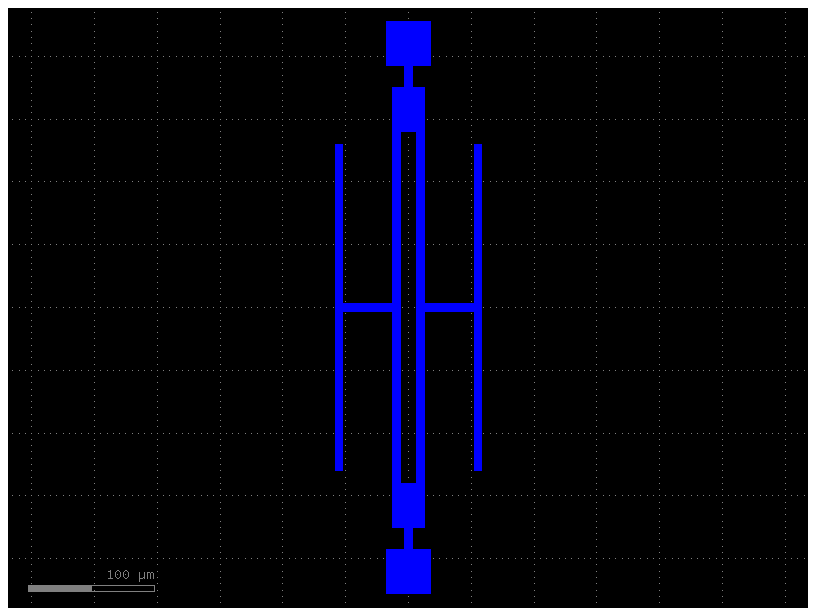

In [182]:
from dataclasses import dataclass
from shapely.geometry.polygon import Polygon
from shapely.affinity import scale

# detf dimensions dataclass
@dataclass
class DimensionsDETF:
    beam_l: float # beam length (y-axis)
    fork_w: float # tuning fork width (x-axis)
    beam_t: float # beam thickness
    elec_l: float # drive electrode length (y-axis)
    elec_arm_w: float # drive electrode arm width (x-axis)

def detf(dim, layer):
    c = gf.Component("detf")

    # tuning fork prong
    rect0 = Polygon([(-dim.fork_w/2, -dim.beam_l/2), (-dim.fork_w/2, dim.beam_l/2), (dim.fork_w/2, dim.beam_l/2), (dim.fork_w/2, -dim.beam_l/2)])
    rect1 = Polygon([(-dim.fork_w/2+dim.beam_t, -dim.beam_l/2+dim.beam_t), (-dim.fork_w/2+dim.beam_t, dim.beam_l/2-dim.beam_t), (dim.fork_w/2-dim.beam_t, dim.beam_l/2-dim.beam_t), (dim.fork_w/2-dim.beam_t, -dim.beam_l/2+dim.beam_t)])

    rect0not1 = rect0 - rect1
    c.add_polygon(rect0not1, layer=layer)

    # prong base
    base_length = 0.1*dim.beam_l
    base_rect = Polygon([(-dim.fork_w/2, -dim.beam_l/2),(dim.fork_w/2, -dim.beam_l/2),(dim.fork_w/2, -dim.beam_l/2+base_length),(-dim.fork_w/2, -dim.beam_l/2+base_length)])
    base_rect_mirr = scale(base_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirrored
    c.add_polygon(base_rect.union(base_rect_mirr), layer=layer)

    # anchor and link
    link_length = 0.05*dim.beam_l
    link_rect = Polygon([(-dim.beam_t/2, -dim.beam_l/2),(dim.beam_t/2, -dim.beam_l/2),(dim.beam_t/2, -dim.beam_l/2-link_length),((-dim.beam_t/2, -dim.beam_l/2-link_length))])
    link_rect_mirr = scale(link_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirrored
    anchor_edge = 0.1*dim.beam_l
    anchor_rect = Polygon([(-anchor_edge/2, -dim.beam_l/2-link_length),(anchor_edge/2, -dim.beam_l/2-link_length),(anchor_edge/2, -dim.beam_l/2-link_length-anchor_edge),(-anchor_edge/2, -dim.beam_l/2-link_length-anchor_edge)])
    anchor_rect_mirr = scale(anchor_rect, xfact=1, yfact=-1, origin=(0, 0)) # mirrored
    c.add_polygon(link_rect.union(link_rect_mirr), layer=layer)
    c.add_polygon(anchor_rect.union(anchor_rect_mirr), layer=layer)
    
    # drive electrode arm
    drive_elec_arm = Polygon([(-dim.fork_w/2, -dim.beam_t/2),(-dim.fork_w/2, dim.beam_t/2),(-dim.fork_w/2-dim.elec_arm_w, dim.beam_t/2),(-dim.fork_w/2-dim.elec_arm_w, -dim.beam_t/2)])
    drive_elec_arm_mirr = scale(drive_elec_arm, xfact=-1, yfact=1, origin=(0, 0)) # mirrored
    c.add_polygon(drive_elec_arm.union(drive_elec_arm_mirr), layer=layer)

    # drive electrode
    drive_elec_origin = -dim.fork_w/2-dim.elec_arm_w
    drive_elec = Polygon([(drive_elec_origin,-dim.elec_l/2),(drive_elec_origin, dim.elec_l/2),(drive_elec_origin-dim.beam_t, dim.elec_l/2),(drive_elec_origin-dim.beam_t, -dim.elec_l/2)])
    drive_elec_mirr = scale(drive_elec, xfact=-1, yfact=1, origin=(0,0)) # mirrored
    c.add_polygon(drive_elec.union(drive_elec_mirr), layer=layer)
    
    return c

# dimensions in µm
dim_detf = DimensionsDETF(
    beam_l=350,
    fork_w=25,
    beam_t=6,
    elec_l=260,
    elec_arm_w=40,
)

detf_c = detf(dim_detf, biomems_pdk.layers['coating'])
detf_c.plot()

Now, let's duplicate it and create the drive electrode structures (where the varying voltage from the control loop is applied), fixed in the silicon.

In [264]:
@dataclass
class DimensionsOuterDriveElec:
    l: float # drive electrode length (y-axis)
    w: float # drive electrode width (x-axis)

def outer_drive_electrode(dim, layer):
    c = gf.Component("drive_electrode")

    drive_elec_fixed = Polygon([(-dim.w/2, -dim.l/2),(-dim.w/2, dim.l/2),(dim.w/2, dim.l/2),(dim.w/2, -dim.l/2)])
    c.add_polygon(drive_elec_fixed, layer=layer)
    
    return c

@dataclass
class DimensionsInnerElec: 
    vert_l: float # electrode vertical length
    hor_l: float # electrode horizontal length
    cont_w: float # contact width
    cont_h: float # contact height
    t: float # electrode prong thickness

def inner_electrode(dim, layer):
    c = gf.Component("inner_electrode")

    elec_beam = Polygon([(0, 0),(dim.t, 0),(dim.t, dim.vert_l),(0, dim.vert_l)])
    hor_beam = Polygon([(0, dim.vert_l),(dim.hor_l, dim.vert_l),(dim.hor_l, dim.vert_l-dim.t),(0, dim.vert_l-dim.t)])
    contact_rect = Polygon([(dim.hor_l, dim.vert_l),(dim.hor_l-dim.cont_w, dim.vert_l),(dim.hor_l-dim.cont_w, dim.vert_l+dim.cont_h),(dim.hor_l, dim.vert_l+dim.cont_h)])
    
    c.add_polygon(elec_beam, layer=layer)
    c.add_polygon(hor_beam, layer=layer)
    c.add_polygon(contact_rect, layer=layer)

    return c

# dimensions in µm
dim_drive_elec = DimensionsOuterDriveElec(
    l=260,
    w=40,
)
drive_elec_c = drive_electrode(dim_drive_elec, biomems_pdk.layers['coating'])

# dimensions in µm
dim_inner_drive_elec = DimensionsInnerElec(
    vert_l = 150,
    hor_l = 60,
    cont_w = 60,
    cont_h = 60,
    t = 12,
)
inner_drive_elec_c = inner_electrode(dim_inner_drive_elec, biomems_pdk.layers['coating'])

Lastly, let's define the sense electrodes, used to detect the position of the resonator through a *motional current*. This current gets generated when the distance between the sense electrode and the resonator changes, which in turn varies the capacitance between these structures.

In [265]:
# dimensions in µm
dim_sense_elec = DimensionsInnerElec(
    vert_l = 150,
    hor_l = 85,
    cont_w = 50,
    cont_h = 60,
    t = 6,
)
sense_elec_c = inner_electrode(dim_sense_elec, biomems_pdk.layers['coating'])

Merging these building blocks, the final mechanical structure with all electrodes can be drawn:

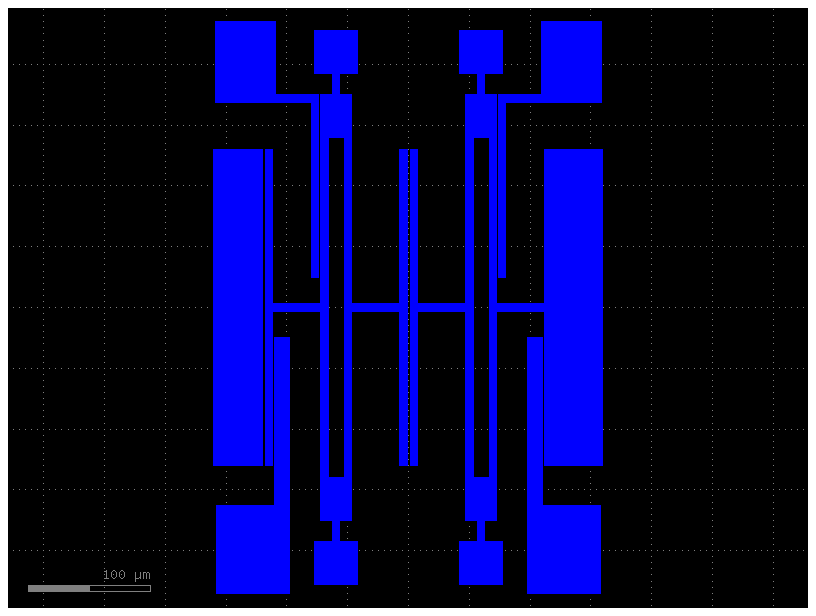

In [266]:
def two_way_coupled_resonator(
    detf, dim_detf, coupling_gap, 
    drive_elec, dim_drive_elec,
    inner_drive_elec, dim_inner_drive_elec,
    sense_elec, dim_sense_elec,
):
    electrode_gap = coupling_gap

    c = gf.Component("two_way_coupled_resonator")
    total_detf_length = dim_detf.fork_w + 2*dim_detf.elec_arm_w + 2*dim_detf.beam_t
    
    res1 = c.add_ref(detf)
    res2 = c.add_ref(detf)
    res1.move([-total_detf_length/2 - electrode_gap/2, 0])
    res2.move([total_detf_length/2 + electrode_gap/2 ,0])

    elec1 = c.add_ref(drive_elec)
    elec2 = c.add_ref(drive_elec)
    elec1.move([-total_detf_length - dim_drive_elec.w/2 - coupling_gap/2 - electrode_gap, 0])
    elec2.move([total_detf_length + dim_drive_elec.w/2 + coupling_gap/2 + electrode_gap, 0])

    sense_elec_pos_x = coupling_gap/2 + dim_detf.beam_t + dim_detf.elec_arm_w + dim_detf.fork_w + coupling_gap
    sense_elec_pos_y = dim_detf.beam_l/2 - dim_sense_elec.vert_l
    sense_elec1 = c.add_ref(sense_elec)
    sense_elec2 = c.add_ref(sense_elec.mirror())
    sense_elec1.move([sense_elec_pos_x, sense_elec_pos_y])
    sense_elec2.move([-sense_elec_pos_x, sense_elec_pos_y])

    inner_elec_pos_x = coupling_gap/2 + dim_detf.beam_t + 2*dim_detf.elec_arm_w + dim_detf.fork_w - dim_inner_drive_elec.t - coupling_gap
    inner_elec_pos_y = dim_detf.beam_l/2 - dim_sense_elec.vert_l
    inner_elec1 = c.add_ref(inner_drive_elec)
    inner_elec2 = c.add_ref(inner_drive_elec)
    inner_elec1.mirror_y()
    inner_elec2.mirror()
    inner_elec2.mirror_y()
    inner_elec1.move([inner_elec_pos_x, -inner_elec_pos_y])
    inner_elec2.move([-inner_elec_pos_x, -inner_elec_pos_y])

    return c

two_way_coupled_resonator(detf_c, dim_detf, 2, drive_elec_c, dim_drive_elec, inner_drive_elec_c, dim_inner_drive_elec, sense_elec_c, dim_sense_elec).plot()

*Disclaimer: some dimensions (especially small gaps) may seem off in the plot, but in the actual .gds they are correct.*

And finally, to get the GDS of our MEMS design, because of our chosen manufacturing strategy, we must draw structures for all layers from the silicon substrate up to metal #5:

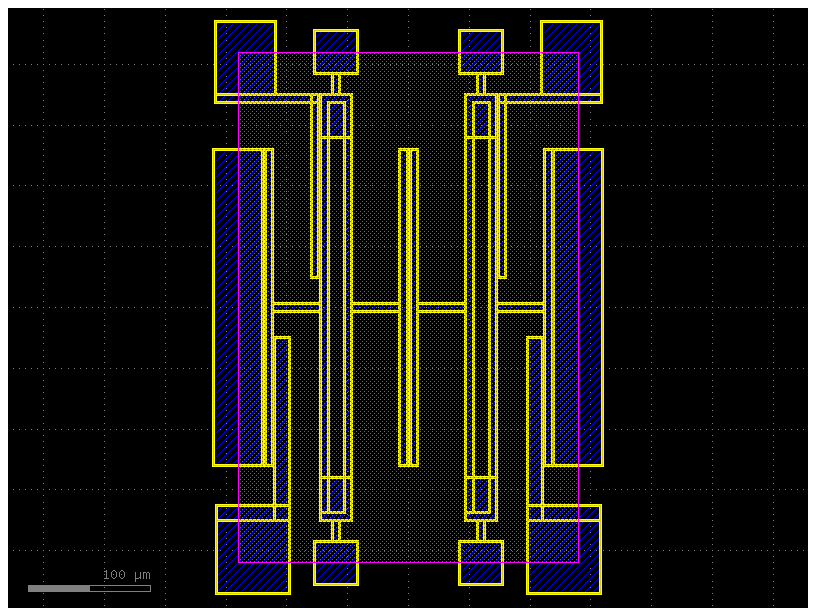

In [269]:
mems_layers = ['li1drawing', 'licon1drawing', 'mcondrawing', 'met1drawing', 'viadrawing', 'met2drawing', 'via2drawing', 'met3drawing', 'via3drawing',
               'met4drawing', 'via4drawing', 'met5drawing']

coupling_gap = 2

# create CMOS process layers
coupled_resonators = gf.Component("coupled_resonators_all_layers")
for layer in mems_layers:
    resonator = detf(dim_detf, biomems_pdk.layers[layer])
    drive_elec = drive_electrode(dim_drive_elec, biomems_pdk.layers[layer])
    inner_drive_elec = inner_electrode(dim_inner_drive_elec, biomems_pdk.layers[layer])
    sense_elec = inner_electrode(dim_sense_elec, biomems_pdk.layers[layer])
    
    coupled_resonators.add_ref(
        two_way_coupled_resonator(resonator, dim_detf, coupling_gap, drive_elec, dim_drive_elec, inner_drive_elec, dim_inner_drive_elec, sense_elec, dim_sense_elec)
    )

# create silicon subtrate trench
total_detf_length = dim_detf.fork_w + 2*dim_detf.elec_arm_w + 2*dim_detf.beam_t
total_two_way_detf_x = 2*total_detf_length + coupling_gap
total_two_way_detf_y = dim_detf.beam_l + 2*(0.05*dim_detf.beam_l + 0.1*dim_detf.beam_l)
trench_x = total_two_way_detf_x + 2*coupling_gap + dim_drive_elec.w
trench_y = total_two_way_detf_y - 0.1*dim_detf.beam_l

trench_rect = gf.components.rectangle(size=(trench_x, trench_y), layer=biomems_pdk.layers['trench'])
trench_rect_ref = coupled_resonators.add_ref(trench_rect)
trench_rect_ref.move([-trench_x/2,-trench_y/2])

coupled_resonators.plot()

Let's now add the coating necessary to bind HER2 molecules in one of the resonators:

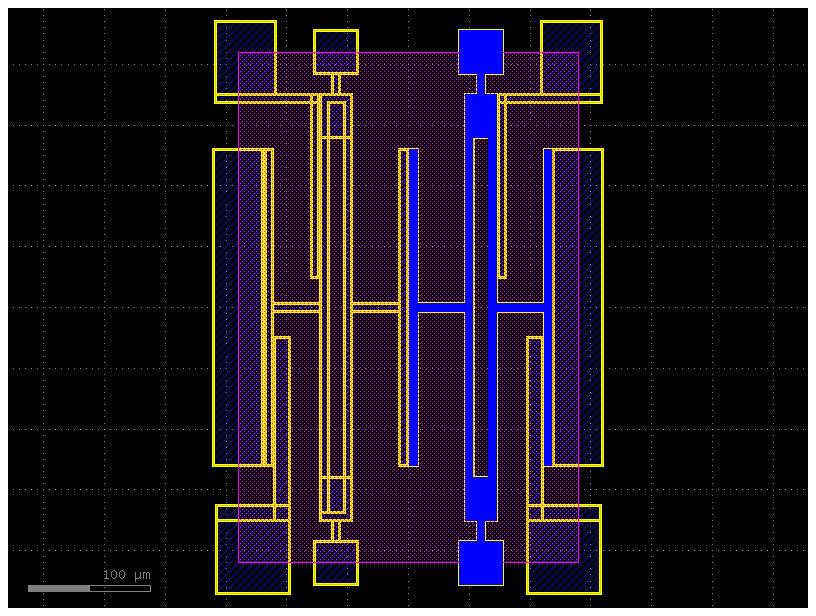

In [262]:
res_coating = detf(dim_detf, biomems_pdk.layers['coating'])
res_coating_ref = coupled_resonators.add_ref(res_coating)
res_coating_ref.move([total_detf_length/2 + coupling_gap/2 ,0])

coupled_resonators.plot()

Now finish by saving the GDSII file.

In [263]:
coupled_resonators.write_gds("coupled_resonators.gds")

2023-12-01 22:47:28.434 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'coupled_resonators.gds'


PosixPath('coupled_resonators.gds')

### Step 3: Simulating the mechanical microsystem

AttributeError: 'GdsLibrary' object has no attribute 'cell_dict'

### Step 4: Designing the analog/digital front-end

### Step 5: Generating the front-end physical layout

With the circuit simulated in Spice using the models from SKY130, we may proceed to its physical layout. Being a mixed-signal design, it's not trivial to automatically generate a physical layout since most open-source tools are aimed towards fully digital synthesis, such as OpenROAD. To make our physical layout generation step feasible, we've established the following strategy:

1. Generate a .gds and a .lef for each cell not present in SKY130
2. Create a top-down Verilog module describing the circuit
3. Run OpenROAD-Flow-Scripts

Cells not present in SKY130 include the open-source IPs (operational amplifiers and comparator), the resistors, the capacitors and the MEMS device. We can treat the MEMS device just like any other microelectronic cell, since it's basically an atypical GDS geometry with ports just like other cells; the OpenROAD router *should* detect it correctly. Because of its sizes, all of these components will be added as macros in the digital design flow.

Furthermore, for OpenROAD-Flow-Scripts, a custom PDN (power delivery network) script will be written to account for the two voltage domains (+-1.8V and GND for the analog stages, 3.3V and GND for the digital stages).

#### Generating .gds and .lef for each macro

For the open-source IPs, we can just copy the Magic (.mag) files from their repositories, and convert them to .gds and .lef:

In [ ]:
!mkdir gds/
!cp ...
!cp ...

In [315]:
%%writefile magic_to_gds.sh

# Assign input .mag file to a variable
input_mag_file="$1"

# Extract the file name from input .mag
file_name=$(basename -- "$input_mag_file")
file_name_no_ext="${file_name%.*}"

# Open magic and convert to gds
conda-env/bin/magic -dnull -noconsole -T conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.tech -rcfile conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc <<EOF
load $input_mag_file.mag
gds write $file_name_no_ext.gds
lef write $file_name_no_ext.lef
quit -noprompt
EOF

Writing magic_to_gds.sh


In [317]:
%%shell
bash ./magic_to_gds.sh avsd_opamp/layout_design/avsd_opamp_layout.mag
bash ./magic_to_gds.sh avsdcmp_3v3_sky130/Layout/comparator.mag

UsageError: Cell magic `%%shell` not found.


In [ ]:
<<see Colab for the rest>>

For the capacitors, gdsfactory's sky130 extension provides a helpful MiMCAP (metal-insulator-metal capacitor) parameterized cell generator, which we'll use. By looking at the layer stack diagram for SKY130 (https://skywater-pdk.readthedocs.io/en/main/rules/assumptions.html#process-stack-diagram -- add to refs), we see that the technology supports two types of capacitors $-$ *capm* (between metals 3 and 4) and *cap2m* (between metals 4 and 5):

![](./img/metal_stack.png)

9.84618225e-12 F


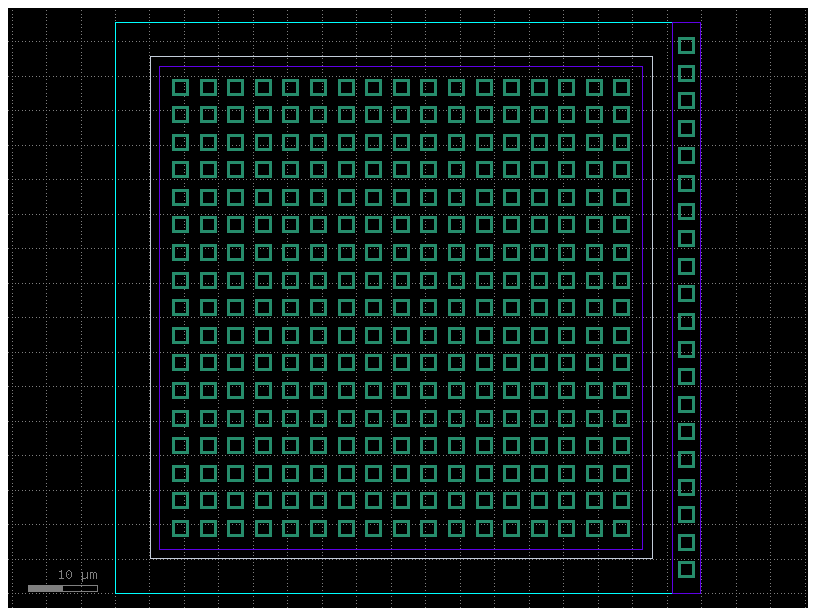

In [319]:
# Generate mimcap with gdsfactory
from sky130.pcells import mimcap_1

# Capacitance formula (from .spice model)
w = 70
l = 70

m3_dw = -0.025e-6
tol_m3 = 0
camimc=  2.00e-15
cpmimc = 0.19e-15

wc = w + m3_dw*1e6 + tol_m3*1e6
lc = l + m3_dw*1e6 + tol_m3*1e6
carea = camimc*wc*lc
cperim = cpmimc*(wc+lc)*2
capacitance = carea + cperim

print(capacitance, "F")

capacitor1 = mimcap_1(
      m3_layer=(70, 20),
      via3_size=(2, 2),
      via3_layer=(70, 44),
      via3_enclosure=(0.9, 0.9),
      via3_spacing=(2, 2),
      m4_spacing=3,
      m4_r_length=4,
      m4_layer=(71, 20),
      m4_length=l,
      m4_width=w,
      capm_layer=(89, 44),
      m4_enclosure=(1.4, 1.4),
      capm_enclosure=(5, 5),
)
capacitor1.rename("capacitor1")

capacitor1.plot()

In [331]:
from sky130.components import *
type(sky130_fd_sc_hd__a2111o_1().ports['VGND'])
#capacitor1.add_port()

<class 'gdsfactory.port.Port'>

In [312]:
capacitor1.write_gds("gds/capacitor1.gds")

2023-12-03 09:18:00.659 | INFO     | gdsfactory.component:_write_library:1913 - Wrote to 'gds/capacitor1.gds'


PosixPath('gds/capacitor1.gds')

To generate the capacitor .lef, we can use Magic to read the .gds and write the .lef:

In [318]:
%%writefile lef_to_gds.sh

# Assign input .gds file to a variable
input_gds_file="$1"

# Extract the file name from input .gds
file_name=$(basename -- "$input_gds_file")
file_name_no_ext="${file_name%.*}"

# Open magic and convert to gds
conda-env/bin/magic -dnull -noconsole -T conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.tech -rcfile conda-env/share/pdk/sky130A/libs.tech/magic/sky130A.magicrc <<EOF
gds read $input_gds_file
lef write $file_name_no_ext.lef
quit -noprompt
EOF

Writing lef_to_gds.sh


In [ ]:
%%shell
bash ./lef_to_gds.sh gds/capacitor1.gds

For the resistances, we've chosen to not integrate them, and instead provide pins for external connections, as SKY130 documentation (https://skywater-pdk.readthedocs.io/en/main/rules/device-details.html#generic-resistors -- add as ref) states that resistances from the PDK are not recommended for analog designs. This will increase parasitics in the device, and ideally two versions of the circuit should be tested in a lab $-$ one with integrated resistors, and another with external resistors $-$ to decide if performance is acceptable.

todo: add ports in MEMS gds and in capacitor gds

### Creating a Verilog module for the circuit

Let's start by creating Verilog modules to describe the circuits that won't be synthesized: the opamp, the comparator, and the capacitor. Supply pins don't have to be included.

In [314]:
!mkdir rtl/

In [ ]:
%%writefile rtl/blackboxes.v

// Opamp
(* keep *)
(* blackbox *) module avsd_opamp_layout
(
    input in1, // inverting input
    input in2, // non-inverting input
    output out2 // output
);
parameter dont_touch = "on";
endmodule

// Comparator
(* keep *)
(* blackbox *) module comparator
(
    input en,
    input inn,
    input inp,
    input net4, // Ihyst (connect between net4 and vcc)
    output vout
);
parameter dont_touch = "on";
endmodule

// MiM capacitor
(* keep *)
(* keep_hierarchy *)
(* blackbox *) module capacitor
(
    input 
    output
);
parameter dont_touch = "on";
endmodule

Since the circuit will have two voltage domains, we'll create a Verilog file containing the cells for each of them. First, we create the Verilog description for the individual cells, then for the domains containing the cells.

In [313]:
%%writefile rtl/dig_voltage_3v3.v
module dig_voltage_3v3
(

);




endmodule

Writing my_verilog_module.v


### Step 6: Integrating the systems

## Conclusion

## References

<a id='ref1-biomarker'></a>
[1] https://www.cancer.org/cancer/diagnosis-staging/tests/biomarker-tests.html

<a id='ref2-HER2'></a>
[2] http://www.scielo.org.ve/scielo.php?script=sci_arttext&pid=S0535-51332008000100008&lng=es&nrm=iso

p citar artigo escrito em outro idioma: Author Last Name, First Initial. (Year Published). Title in the original language [Translated title]. Place of Publication: Publisher.

<a id='ref3-coupledDETF'></a>
[3] https://ieeexplore.ieee.org/document/5210140/

<a id='ref4-HER2serum'></a>
[4] https://bmccancer.biomedcentral.com/articles/10.1186/s12885-020-07545-2

<a id='ref5-cmosmems'></a>
[5] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6189935/

<a id='ref6-driecmosmems'></a>
[6] https://www.frontiersin.org/articles/10.3389/fmech.2022.894484/full

<a id='ref7-science'></a>
[7] https://science.xyz/docs/d/mems-soi/index

<a id='ref8-her2antibodies'></a>
[8] https://www.frontiersin.org/journals/oncology/articles/10.3389/fonc.2022.917439/full

<a id='ref9-quantumdot'></a>
[9] https://molmed.biomedcentral.com/articles/10.1186/s10020-019-0108-z

<a id='ref10-layerbylayer'></a>
[10] https://novapublishers.com/shop/layer-by-layer-deposition-development-and-applications/ (put the book)

## Acknowledgements?

my advisor in CentraleSupélec, with whom I learned a lot about MEMS design and fabrication techniques
my partner, who is studying medicine and helped me with biophysics and biochemistry intrinsics
the open source silicon community, that is creating contest opportunities like this and changing the way engineers learn and use microelectronics for a better and more inclusive field